# Inference on S&P stylized BraTS

We compare the performance of models trained on stylized datasets on differently stylized datasets.



The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split
from tqdm import tqdm
import pickle

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import (ConvertToMultiChannelBasedOnBratsClassesd,
                                   SaltAndPepper,
                                   RandFourierDiskMaskd,
                                  RandPlaneWaves_ellipsoid)

from utils import show_slice_and_fourier, ReCompose, BratsValIterDataset, model_evaluation
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 2.5.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Model comparisons

In [2]:
sap_transforms = {'baseline':None, 
                  'sap05':SaltAndPepper(0.05), 
                  'sap10':SaltAndPepper(0.10), 
                  'sap15':SaltAndPepper(0.15), 
                  'sap25':SaltAndPepper(0.25), 
                  'sap35':SaltAndPepper(0.35)}

sap_dataloaders = BratsValIterDataset(root_dir, 50, sap_transforms, True)

# Inference on planes datasets

Load models

In [3]:
models_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/'

# baseline model
path = os.path.join(models_dir, 'baseline_model/best_metric_model_baseline.pth')
baseline = model_evaluation(path, 'baseline_model')

# gibbs models
path = os.path.join(models_dir, 'stylized_Gibbs25/best_metric_model_Gibbs25.pth')
gibbs25 = model_evaluation(path, 'Gibbs25_model')

path = os.path.join(models_dir, 'stylized_Gibbs20/best_metric_model_Gibbs20.pth')
gibbs20 = model_evaluation(path, 'Gibbs20_model')

path = os.path.join(models_dir, 'stylized_Gibbs15/best_metric_model_Gibbs15.pth')
gibbs15 = model_evaluation(path, 'Gibbs15_model')

path = os.path.join(models_dir, 'stylized_Gibbs12.5/best_metric_model_Gibbs12.5.pth')
gibbs12p5 = model_evaluation(path, 'Gibbs12.5_model')

path = os.path.join(models_dir, 'stylized_Gibbs10/best_metric_model_Gibbs10.pth')
gibbs10 = model_evaluation(path, 'Gibbs10_model')

path = os.path.join(models_dir, 'stylized_Gibbs9/best_metric_model_Gibbs9.pth')
gibbs9 = model_evaluation(path, 'Gibbs9_model')


# planes models
path = os.path.join(models_dir, 'stylized_planes12/best_metric_model_planes_a55.0b55.0c30.0_int12.0.pth')
planes12 = model_evaluation(path, 'Planes12_model')

path = os.path.join(models_dir, 'stylized_planes13/best_metric_model_planes_a55.0b55.0c30.0_int13.0.pth')
planes13 = model_evaluation(path, 'Planes13_model')

path = os.path.join(models_dir, 'stylized_planes14/best_metric_model_planes_a55.0b55.0c30.0_int14.0.pth')
planes14 = model_evaluation(path, 'Planes14_model')

path = os.path.join(models_dir, 'stylized_planes15/best_metric_model_planes_a55.0b55.0c30.0_int15.0.pth')
planes15 = model_evaluation(path, 'Planes15_model')

path = os.path.join(models_dir, 'stylized_planes16/best_metric_model_planes_a55.0b55.0c30.0_int16.0.pth')
planes16 = model_evaluation(path, 'Planes16_model')

path = os.path.join(models_dir, 'stylized_planes17/best_metric_model_planes_a55.0b55.0c30.0_int17.0.pth')
planes17 = model_evaluation(path, 'Planes17_model')

# salt and pepper models
path = os.path.join(models_dir, 'stylized_model_sap0.05/stylized_model_sap0.05.pth')
sap05 = model_evaluation(path, 'sap05')

path = os.path.join(models_dir, 'stylized_model_sap0.15/stylized_model_sap0.15.pth')
sap15 = model_evaluation(path, 'sap15')

path = os.path.join(models_dir, 'stylized_model_sap0.25/stylized_model_sap0.25.pth')
sap25 = model_evaluation(path, 'sap25')

path = os.path.join(models_dir, 'stylized_model_sap0.35/stylized_model_sap0.35.pth')
sap35 = model_evaluation(path, 'sap35')

# wraparound models
path = os.path.join(models_dir, 'stylized_model_wrap0.0/stylized_model_wrap0.0.pth')
wrap0 = model_evaluation(path, 'wrap0_model')

path = os.path.join(models_dir, 'stylized_model_wrap0.25/stylized_model_wrap0.25.pth')
wrap0p25 = model_evaluation(path, 'wrap0.25_model')

path = os.path.join(models_dir, 'stylized_model_wrap0.5/stylized_model_wrap0.5.pth')
wrap0p5 = model_evaluation(path, 'wrap0.5_model')

path = os.path.join(models_dir, 'stylized_model_wrap0.75/stylized_model_wrap0.75.pth')
wrap0p75 = model_evaluation(path, 'wrap0.75_model')

In [4]:
eval_list = [baseline,
             gibbs25,
             gibbs20,
             gibbs15,
             gibbs12p5,
             gibbs10,
             gibbs9,
             planes12,
             planes13,
             planes14,
             planes15,
             planes16,
             planes17,
             sap05,
             sap15,
             sap25,
             sap35,
             wrap0,
             wrap0p25,
             wrap0p5,
             wrap0p75
            ]


for name, dl in sap_dataloaders:
    for model in eval_list:
        model.add_eval(name, dl)

print('evaluations done.')

for model in eval_list:
    model.save()
    
print('evaluations saved.')

100%|██████████| 24/24 [00:18<00:00,  1.28it/s]

evaluations done.
evaluations saved.


In [5]:
def plot_model_performance(gibbs_values:list, model_evals:list, metric:str, figsize:tuple = None, xlim:tuple=None, ylim:tuple=None, mark:str='-', c=None):
    '''
    Plots each model's performance over a range of stylized 
    datasets.
    
    Args: 
        gibbs_values = list of Gibbs values associated with each
            test dataset.
        model_evals = instances of the model_evaluation class
            for each model to evaluate.
        metric = one of [mean, et, tc, wt].
    '''
    metrics_map ={'mean':0, 'et':1, 'tc':2, 'wt':3}
    
    # plot values associated with each dataset.
    # sort strings first. for better plotting, give
    # names to datasets that sort nicely.
    keys = model_evals[0].eval_dict.keys()
    
#     plt.figure(figsize=figsize)
    for model in model_evals:
        vals = []
        for k in keys:
            vals.append(dict(model.eval_dict)[k][metrics_map[metric]])
        plt.plot(gibbs_values,list(vals),mark,label=model.instance_name, c=c)
    plt.legend()
#     plt.xlabel('S&P stylized data')
    plt.title(metric+' Dice score')
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
        plt.yticks(np.arange(min(ylim), max(ylim), .02))
#     plt.show()


In [6]:
baseline_list = [baseline]

gibbs_list =[gibbs25,
             gibbs20,
             gibbs15,
             gibbs12p5,
             gibbs10,
             gibbs9]

planes_list=[planes12,
             planes13,
             planes14,
             planes15,
             planes16,
             planes17]

sap_list =  [sap05,
             sap15,
             sap25,
             sap35]

wrap_list = [wrap0,
            wrap0p25,
            wrap0p5,
            wrap0p75]

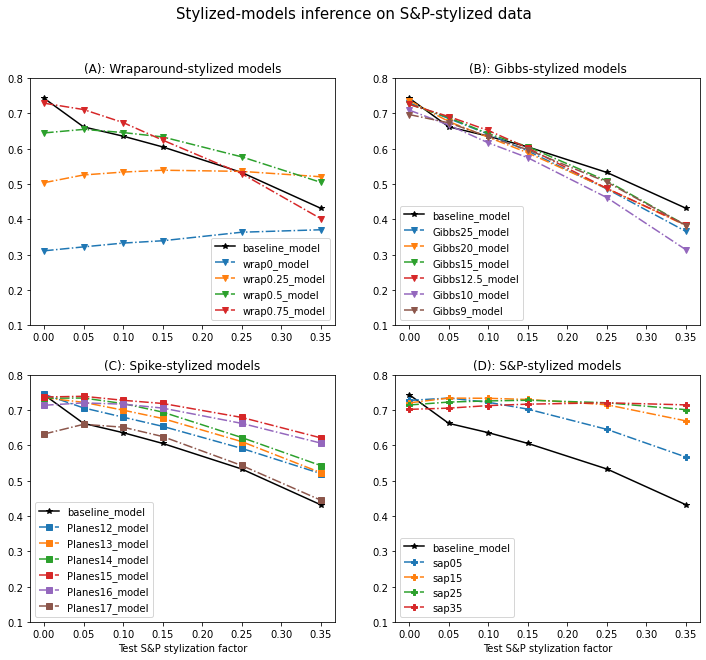

In [9]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35], baseline_list,'mean', mark = '-*', c='k' )
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35], wrap_list,'mean', mark = '-.v' )
plt.yticks(np.arange(.1,.9,.1))
plt.title('(A): Wraparound-stylized models')

plt.subplot(2,2,2)
plot_model_performance([0, 0.05, 0.10, 0.15, 0.25, 0.35], baseline_list,'mean', mark = '-*', c='k' )
plot_model_performance([0, 0.05, 0.10, 0.15, 0.25, 0.35], gibbs_list, 'mean', mark = '-.v' )
plt.yticks(np.arange(.1,.9,.1))
plt.title('(B): Gibbs-stylized models')

plt.subplot(2,2,3)
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35],baseline_list,'mean', mark = '-*', c='k' )
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35], planes_list, 'mean', mark = '-.s')
plt.yticks(np.arange(.1,.9,.1))
plt.title('(C): Spike-stylized models')
plt.xlabel('Test S&P stylization factor')

plt.subplot(2,2,4)
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35], baseline_list,'mean', mark = '-*', c='k' )
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35], sap_list,'mean', mark = '-.P')
plt.yticks(np.arange(.1,.9,.1))
plt.title('(D): S&P-stylized models')
plt.xlabel('Test S&P stylization factor')

plt.suptitle('Stylized-models inference on S&P-stylized data', size=15)
plt.savefig('sap_test_MEAN.png')
plt.show()

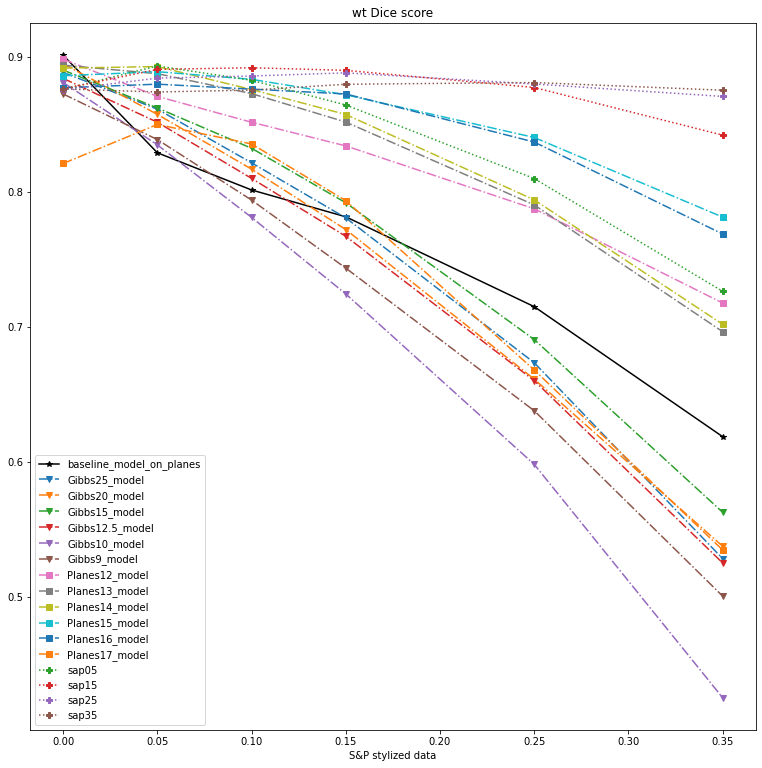

In [17]:
plt.figure(figsize=(13,13))
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35],baseline_list,'wt', mark = '-*', c='k' )
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35],gibbs_list,'wt', mark = '-.v' )
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35],planes_list,'wt', mark = '-.s')
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35],sap_list,'wt', mark = ':P')
plt.savefig('gibbs_planes_sap_on_sap_WT.png',facecolor='white')
plt.show()

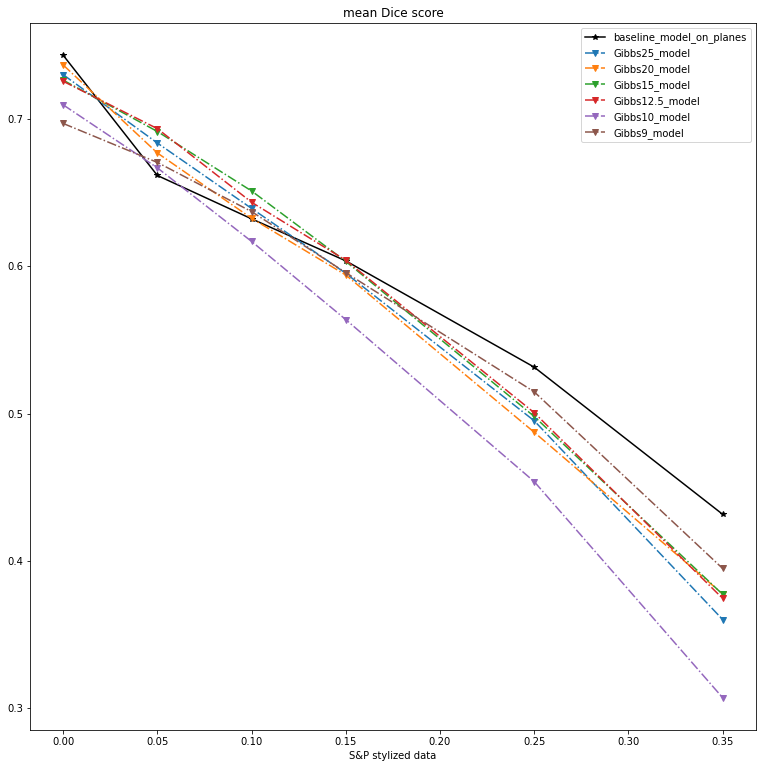

In [22]:
plt.figure(figsize=(13,13))
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35], baseline_list, 'mean', mark = '-*', c='k' )
plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35], gibbs_list, 'mean', mark = '-.v' )
# plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35],planes_list,'mean', mark = '-.s')
# plot_model_performance([0,0.05, 0.10, 0.15, 0.25, 0.35],sap_list,'mean', mark = ':P')
plt.savefig('gibbs_on_sap_MEAN.png',facecolor='white')
plt.show()

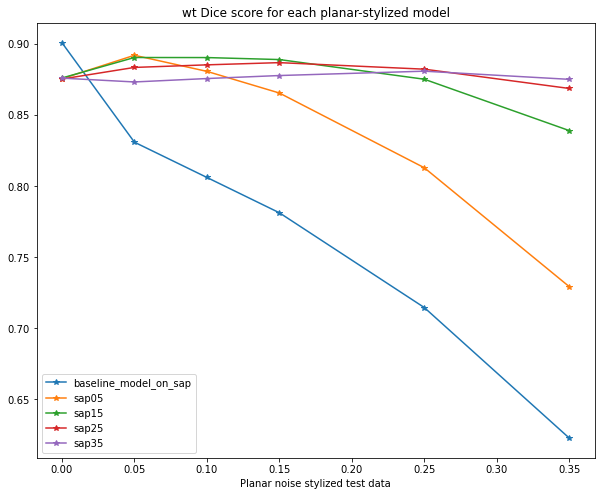

In [61]:
plot_model_performance([0, 0.05, 0.10, 0.15,.25, .35],[baseline, sap05, sap15, sap25, sap35],'wt',figsize=(10,8))

# Gibbs models

In [12]:
%ls

 80_learning_curves/                            Gibbs9_model.pickle
 baseline_gibbs.pickle                          Planes12_model.pickle
'baseline model.pickle'                         Planes14_model.pickle
 brats_segmentation_3d_plane_waves_test.ipynb   Planes15_model.pickle
 compare.py                                     Planes16.5_model.pickle
 Gibbs10_model.pickle                           Planes16_model.pickle
 Gibbs12.5_model.pickle                         Planes17_model.pickle
 Gibbs15_model.pickle                           __pycache__/
 Gibbs20_model.pickle                           Untitled.ipynb
 Gibbs25_model.pickle


In [17]:
baseline = model_evaluation('best_metric_model_baseline.pth', 'baseline model')
gibbs25 = model_evaluation('best_metric_model_Gibbs25.pth', 'Gibbs25_model')
gibbs20 = model_evaluation('best_metric_model_Gibbs20.pth', 'Gibbs20_model')
gibbs15 = model_evaluation('best_metric_model_Gibbs15.pth', 'Gibbs15_model')
gibbs12p5 = model_evaluation('best_metric_model_Gibbs12.5.pth', 'Gibbs12.5_model')
gibbs10 = model_evaluation('best_metric_model_Gibbs10.pth', 'Gibbs10_model')
gibbs9 = model_evaluation('best_metric_model_Gibbs9.pth', 'Gibbs9_model')

baseline.load_dict('baseline_gibbs.pickle')
gibbs25.load_dict('Gibbs25_model.pickle')
gibbs20.load_dict('Gibbs20_model.pickle')
gibbs15.load_dict('Gibbs15_model.pickle')
gibbs12p5.load_dict('Gibbs12.5_model.pickle')
gibbs10.load_dict('Gibbs10_model.pickle')
gibbs9.load_dict('Gibbs9_model.pickle')

In [19]:
planes_data_dict = dict(
    [('planes12_data', test_loader_planes12),
     ('planes14_data', test_loader_planes14),
     ('planes15_data', test_loader_planes15),
     ('planes16_data', test_loader_planes16),
     ('planes16.5_data', test_loader_planes16p5),
     ('planes17_data', test_loader_planes17)
    ])

gibbs_models = [baseline,gibbs25,gibbs20,gibbs15,gibbs12p5,gibbs10,gibbs9]

for x in gibbs_models:
    for name in planes_data_dict:
        x.add_eval(name, planes_data_dict[name])
    x.instance_name = x.instance_name + '_2'
    x.save()

100%|██████████| 24/24 [00:31<00:00,  1.30s/it]


In [20]:
baseline.eval_dict


defaultdict(list,
            {'baseline_data': (0.7432693392038345,
              0.5489715797205766,
              0.7797949202358723,
              0.9010415002703667),
             'planes12_data': (0.7378606622417768,
              0.5440621636807919,
              0.773770198225975,
              0.895749643445015),
             'planes14_data': (0.6510944416125616,
              0.4575871266424656,
              0.6771040807167689,
              0.8185921385884285),
             'planes15_data': (0.6014503948390484,
              0.3955950648523867,
              0.6186110861599445,
              0.7901450420419375),
             'planes16_data': (0.27854293895264465,
              0.10160165720541652,
              0.26536919095087796,
              0.4686579580108325),
             'planes16.5_data': (0.07187439315021038,
              0.0077993803344422,
              0.044744124679709785,
              0.1630796816510459),
             'planes17_data': (0.018005432105079915,

In [27]:
with open('/homes/yc7620/Documents/medical-vision-textural-bias/20_results/20_Gibbs_filters/baseline model.pickle', 'rb') as f:
    a = pickle.load(f)

In [28]:
a

{'model_name': 'best_metric_model_baseline.pth',
 'model': None,
 'instance_name': 'baseline model',
 'eval_dict': defaultdict(list,
             {'baseline_data': (0.7432693392038345,
               0.5489715797205766,
               0.7797949202358723,
               0.9010415002703667),
              'planes12_data': (0.7370974471171697,
               0.5435882521172365,
               0.77201022580266,
               0.895693858464559),
              'planes14_data': (0.657578976203998,
               0.4641460521767537,
               0.6879839698473612,
               0.8206069221099218),
              'planes15_data': (0.5790387243032455,
               0.37668504131337005,
               0.596923024704059,
               0.7635081137220064),
              'planes16_data': (0.2329209834958116,
               0.08787122290717282,
               0.21003801003098488,
               0.4008537183205287),
              'planes16.5_data': (0.06091170820097128,
               0.0109864